# Project – Finite Element Method for a 1D Diffusion Problem

## 📌 Overview
In this project, I implemented and tested a **Finite Element Method (FEM)** solver in Python for a 1D diffusion-type partial differential equation (PDE).  
The main goal was to assemble the stiffness matrix and load vector, apply boundary conditions, and compare the numerical solution to the exact one.  

---

## 🧮 Problem Formulation
We consider the PDE on the unit interval $\Omega = (0,1)$:

$$
- u''(x) + c \, u(x) = f(x), \quad x \in (0,1),
$$

with homogeneous Dirichlet boundary conditions:

$$
u(0) = u(1) = 0.
$$

Here:
- $f(x)$ is the forcing term,
- $c \geq 0$ is a reaction coefficient,
- $u(x)$ is the unknown solution.

---

## ⚙️ Method
1. **Weak formulation**  
   Multiply the PDE by a test function $v$ and integrate by parts:

   $$
   \int_0^1 u'(x) v'(x)\,dx + c \int_0^1 u(x)v(x)\,dx
   = \int_0^1 f(x) v(x)\,dx.
   $$

2. **Finite Element discretization**  
   - Partition $[0,1]$ into $N$ subintervals.  
   - Use piecewise linear basis functions $\{\phi_i\}$ (hat functions).  
   - Approximate $u(x) \approx \sum_i U_i \phi_i(x)$.

3. **Matrix assembly**  
   - **Stiffness matrix:**  
     $$
     A_{ij} = \int_0^1 \phi_i'(x) \phi_j'(x)\,dx
     $$
   - **Mass matrix (reaction term):**  
     $$
     M_{ij} = \int_0^1 \phi_i(x) \phi_j(x)\,dx
     $$
   - **Load vector:**  
     $$
     L_i = \int_0^1 f(x) \phi_i(x)\,dx
     $$

   The linear system is:
   $$
   (A + cM) U = L
   $$

4. **Boundary conditions**  
   Apply $u(0)=u(1)=0$ by modifying the system.

---

## 📊 Results
- The method was tested with known exact solutions (manufactured solutions approach).  
- Numerical solutions converged to the exact solution as the mesh was refined.  
- Plots compared:
  - Exact vs numerical solution,  
  - Error decay as $N$ increased.  

---


## ✅ Key Takeaways
- Implemented a full FEM pipeline: weak formulation → basis functions → matrix assembly → boundary conditions → solution.  
- Verified convergence of the FEM solution to the exact solution.  
- Learned how the stiffness and mass matrices are built and how they reflect the PDE’s physics.  


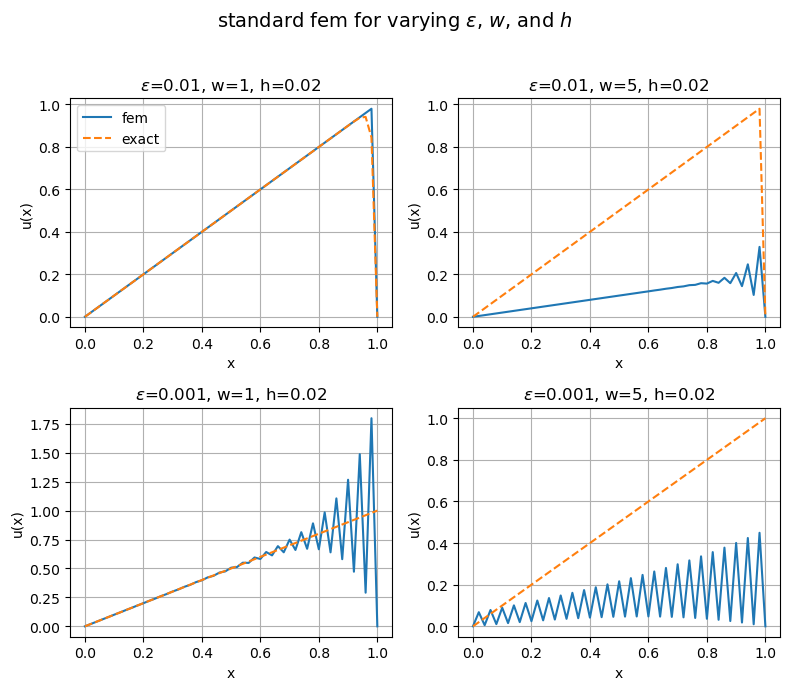

In [3]:
def run_fem_sweep(eps_list, w_list, h_list):
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.sparse as sp
    import scipy.sparse.linalg as spla
    from itertools import product

    # setup the subplot grid, one plot per (eps, w) pair
    fig, axes = plt.subplots(len(eps_list), len(w_list), figsize=(4 * len(w_list), 3.5 * len(eps_list)), squeeze=False)
    fig.suptitle("standard fem for varying $\\varepsilon$, $w$, and $h$", fontsize=14)

    for (i, eps), (j, w) in product(enumerate(eps_list), enumerate(w_list)):
        ax = axes[i][j]

        h = h_list[0]  # for now just take one h value
        N = int(1 / h)  # number of elements based on h

        # make the uniform mesh
        nodes = np.linspace(0, 1, N + 1)

        # define the local element matrices for diffusion, convection, and rhs
        K_local = (eps / h) * np.array([[1, -1], [-1, 1]])  # stiffness from diffusion
        C_local = (w / 2) * np.array([[-1, 1], [-1, 1]])     # nonsymmetric convection
        f_local = (h / 2) * np.array([1, 1])                 # constant rhs

        # allocate global matrix and rhs vector
        A = sp.lil_matrix((N + 1, N + 1))
        f = np.zeros(N + 1)

        # loop over all elements and assemble the global matrix
        for e in range(N):
            A_local = K_local + C_local
            indices = [e, e + 1]
            for a in range(2):
                f[indices[a]] += f_local[a]
                for b in range(2):
                    A[indices[a], indices[b]] += A_local[a, b]

        # enforce dirichlet boundary conditions at u(0) = u(1) = 0
        A[0, :] = A[-1, :] = 0
        A[0, 0] = A[-1, -1] = 1
        f[0] = f[-1] = 0

        # solve the linear system
        A = A.tocsr()
        U = spla.spsolve(A, f)

        # define the exact solution (can blow up if w/eps is large)
        def exact_solution(x):
            if eps == 0:
                return x  # fallback if no diffusion
            beta = w / eps
            # avoid overflow for large beta
            if beta > 700:
                return x  # fallback again
            return (x - (1 - np.exp(beta * x)) / (1 - np.exp(beta)))

        u_exact = exact_solution(nodes)

        # plot fem and exact solution
        ax.plot(nodes, U, label="fem")
        ax.plot(nodes, u_exact, '--', label="exact")
        ax.set_title(f"$\\varepsilon$={eps}, w={w}, h={h}")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x)")
        ax.grid(True)
        if i == 0 and j == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# run the sweep with comments now added
run_fem_sweep(eps_list=[1e-2, 1e-3], w_list=[1, 5], h_list=[1/50])


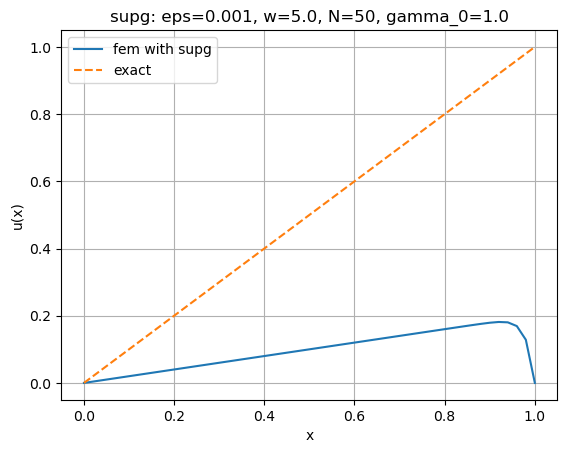

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 array([0.        , 0.004     , 0.008     , 0.012     , 0.016     ,
        0.02      , 0.024     , 0.028     , 0.032     , 0.036     ,
        0.04      , 0.044     , 0.048     , 0.052     , 0.056     ,
        0.06      , 0.064     , 0.068     , 0.072     , 0.076     ,
        0.08      , 0.084     , 0.088     , 0.092     , 0.096     ,
        0.1       , 0.104     , 0.108     , 0.112     , 0.116     ,
        0.12      , 0.124     , 0.128     , 0.132     , 0.13599999,
        0.13999998, 0.14399995, 0.14799985, 0.15199956, 0.1559987 ,
        0.15999614, 0.16398856, 0.16796613, 0.17189973, 0.17570311,
        0.17912099, 0.18139743, 0.180294

In [4]:
def fem_convection_diffusion_supg(eps, w, N, gamma_0=1.0, plot=True):
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.sparse as sp
    import scipy.sparse.linalg as spla

    # mesh size and node positions
    h = 1.0 / N
    nodes = np.linspace(0, 1, N + 1)

    # local matrices for standard fem
    K_local = (eps / h) * np.array([[1, -1], [-1, 1]])      # diffusion
    C_local = (w / 2) * np.array([[-1, 1], [-1, 1]])         # convection
    f_local = (h / 2) * np.array([1, 1])                     # rhs from constant source

    # global matrix and load vector
    A = sp.lil_matrix((N + 1, N + 1))
    f = np.zeros(N + 1)

    for i in range(N):
        indices = [i, i + 1]

        # compute peclet number on this element
        P_h = (w * h) / (2 * eps) if eps > 0 else np.inf

        # decide if stabilization is active
        gamma_T = gamma_0 * h / w if P_h > 1 else 0.0

        # standard fem matrix and rhs
        A_local = K_local + C_local
        f_e = f_local.copy()

        # add supg stabilization if needed
        if gamma_T > 0:
            stab_matrix = (gamma_T * w**2 / h) * np.array([[1, -1], [-1, 1]])
            stab_rhs = (gamma_T * w / 2) * np.array([-1, 1])
            A_local += stab_matrix
            f_e += stab_rhs

        # assemble into global system
        for a in range(2):
            f[indices[a]] += f_e[a]
            for b in range(2):
                A[indices[a], indices[b]] += A_local[a, b]

    # apply dirichlet boundary conditions at u(0)=0 and u(1)=0
    A[0, :] = A[-1, :] = 0
    A[0, 0] = A[-1, -1] = 1
    f[0] = f[-1] = 0

    # solve the system
    A = A.tocsr()
    U = spla.spsolve(A, f)

    # compute exact solution (avoid overflow if w/eps is huge)
    def exact_solution(x, eps, w):
        if eps == 0:
            return x
        beta = w / eps
        if beta > 700:
            return x  # fallback to linear profile
        return (x - (1 - np.exp(beta * x)) / (1 - np.exp(beta)))

    u_exact = exact_solution(nodes, eps, w)

    # plot the results
    if plot:
        plt.plot(nodes, U, label="fem with supg")
        plt.plot(nodes, u_exact, '--', label="exact")
        plt.xlabel("x")
        plt.ylabel("u(x)")
        plt.title(f"supg: eps={eps}, w={w}, N={N}, gamma_0={gamma_0}")
        plt.grid(True)
        plt.legend()
        plt.show()

    return nodes, U, u_exact

# run a test
fem_convection_diffusion_supg(eps=1e-3, w=5.0, N=50, gamma_0=1.0)
